In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from  pathlib import Path


In [2]:
from segmentation_utils.dataloader import (
    ImageCircleDatasetV2,
    ImageCircleDatasetSeperate,
)



/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


In [3]:

def inference_whole_slide(model, slide_pth: Path, max_frame: int):

    image_file_paths = sorted(list(slide_pth.glob("*.jpg")), key=lambda x: int(x.stem))[
        :max_frame
    ]

    images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

    val_dataset = ImageCircleDatasetV2(images, images, images, images, predict=True)

    val_dataloader = DataLoader(val_dataset, batch_size=32)

    model.eval()
    from torch.cuda.amp import autocast

    all_masks = []
    for inpt_images, _ in val_dataloader:
        with torch.no_grad():
            # with autocast():

            pred_mask = model(inpt_images.to(device))
            #
            # masks = torch.softmax(pred_mask,axis=1).cpu().numpy()>0.05
            masks = torch.sigmoid(pred_mask).cpu().numpy() > 0.01

            
            all_masks.extend([msk for msk in masks])
            # breakpoint()

    pn_size = []
    final_images = []
    upscaled_masks = []
    isolated_pns = []
    for pil_img, mask in zip(images[:], all_masks[:]):
        # Ensure the mask is 2D by removing extra dimensions
        # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
        image_ar = np.stack(3 * [np.array(pil_img)])

        upscaled_mask1 = cv2.resize(
            mask[1].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask2 = cv2.resize(
            mask[0].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask3 = cv2.resize(
            mask[2].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )

        # pn_size.append(upscaled_mask.sum())

        upscaled_masks.append((upscaled_mask1, upscaled_mask2, upscaled_mask3))
        image_pn_isolated = image_ar.copy()
        image_pn_isolated[:, ~upscaled_mask1.astype(bool)] = 0
        isolated_pns.append(image_pn_isolated.transpose(1, 2, 0))
        image_ar[0, upscaled_mask1.astype(bool)] = 1
        image_ar[1, upscaled_mask2.astype(bool)] = 1
        # image_ar[2, upscaled_mask3.astype(bool)] = 1

        final_images.append(Image.fromarray(image_ar.transpose(1, 2, 0)))

    return (
        final_images,
        upscaled_masks,
    )


In [4]:
df = pd.read_excel("/home/tsakalis/ntua/phd/pronuclei_detector/data/whole_dna_tsakalis.xlsx")

In [5]:

df['embryo_id'] = df['Slide ID'] + "_"+df['Well'].astype(str)

In [6]:
pth_lib = Path('/media/tsakalis/STORAGE/phd/raw_timelapses')
pth_lib2 = Path("/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses")

In [7]:
def get_slide_ids(pth: Path) -> list[str]:
    return [(x.name, x) for x in list(pth.glob('*'))]



In [8]:
file_avail = pd.DataFrame(get_slide_ids(pth_lib)+get_slide_ids(pth_lib2), columns=['embryo_id', 'pth']).drop_duplicates()

In [9]:
df['embryo_id'].sample(3)

69     D2019.04.06_S01975_I0149_D_2
79     D2019.04.22_S01986_I0149_D_9
150    D2018.11.26_S01909_I0149_D_1
Name: embryo_id, dtype: object

In [10]:
file_avail.sample(1)

,embryo_id,pth
258,D2018.09.17_S01862_I0149_D_11,/home/tsakalis/ntua/phd/cellforge/cellforge/da...


In [11]:
merged_df = pd.merge(df, file_avail,how='inner', on='embryo_id')

In [12]:
target_column = 'PGT RESULT'

In [13]:
merged_df.shape

(153, 142)

In [14]:
import re
from collections import defaultdict

def normalize_label(label: str) -> str:
    """
    Normalize and categorize a PGT result label into predefined groups.
    """
    text = label.lower().strip()
    text = re.sub(r'[\s,]+', ' ', text)
    text = re.sub(r'\s?/\s?', '/', text)
    text = text.rstrip('.')
    
    patterns = {
        'Unbalanced translocation': r'unbalanced.*translocation',
        'Balanced translocation': r'balanced.*translocation',
        'Monosomy': r'\bmonosomy\b',
        'Trisomy': r'\btrisomy\b',
        'Mosaic': r'\bmosaic\b',
        'Complex abnormalities': r'complex',
        'Normal/Euploid': r'\b(normal|euploid|no amplif|balanced/euploid)\b',
        'No result': r'no result|no amplification'
    }
    
    for category, pattern in patterns.items():
        if re.search(pattern, text):
            return category
    return 'Other'

def encode_labels(labels):
    """
    Encode each label into a numeric category ID.
    Returns:
      - numeric_labels: List[int] of encoded category IDs
      - mapping: Dict[str, int] mapping category names to IDs
    """
    # Determine unique categories in order of first appearance
    unique_cats = []
    for label in labels:
        cat = normalize_label(label)
        if cat not in unique_cats:
            unique_cats.append(cat)
    
    # Build mapping
    mapping = {cat: idx for idx, cat in enumerate(unique_cats)}
    
    # Encode labels
    numeric_labels = [mapping[normalize_label(label)] for label in labels]
    return numeric_labels, mapping

def binary_encode_labels(labels):
    binary = []
    for label in labels:
        cat = normalize_label(label)
        if cat in ('Normal/Euploid', 'Balanced translocation'):
            binary.append(1)
        else:
            binary.append(0)
    return binary
# Example usage
sample_labels = [
    'unbalanced',
    'balanced for the translocation, X0',
    'monosomy 16/female',
    'trisomy 21',
    'mosaic monosomy 9,22 (70%)',
    'complex mosaic, XXX',
    'normal',
    'no result'
]

encoded, mapping = encode_labels(merged_df[target_column].tolist())


print("Mapping (category -> ID):")
for cat, idx in mapping.items():
    print(f"  {cat}: {idx}")
print("\nEncoded labels:")
print(encoded)


Mapping (category -> ID):
  Other: 0
  Balanced translocation: 1
  Unbalanced translocation: 2
  Monosomy: 3
  Mosaic: 4
  Trisomy: 5
  Complex abnormalities: 6
  Normal/Euploid: 7
  No result: 8

Encoded labels:
[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 5, 3, 0, 3, 5, 6, 3, 3, 3, 3, 6, 3, 6, 3, 3, 4, 3, 5, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 0, 3, 5, 0, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 7, 7, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 3, 3, 1, 2, 2, 2, 2, 0, 2, 2, 2, 6, 6, 3, 3, 1, 1, 2, 5, 2, 2, 2, 2, 3, 3, 5, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 5, 3, 3, 0, 5, 6, 3, 3, 3, 3, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 1, 7, 7, 0, 7, 7, 8, 8]


In [15]:
def classify_pgt_result(pgt_string):
    """
    Classifies a PGT test result string into 0 (bad/anomaly) or 1 (ok).
    0: aneuploid, anomaly detected, mosaic, unbalanced, no result, etc.
    1: euploid, normal, balanced carrier without other anomalies.
    """
    s = pgt_string.lower().strip()

    # --- Step 1: Check for definitive "bad" conditions ---
    # These conditions generally make the result "bad" (0).
    # Keywords are checked case-insensitively after stripping whitespace.
    bad_indicators = [
        'unbalanced', 'monosomy', 'trisomy', 'x0', 'xxx', 'xxy', 'xyy', 'nullisomy',
        'partial',  # Covers "partial trisomy", "partial monosomy", "partial loss"
        'structural monosomy', 'structural trisomy',
        'isochromosome',
        'xp+',  # Indicates a gain, e.g., +Xp
        '-xp',  # Indicates a loss, e.g., -Xp (though monosomy X would also catch full -X)
        'complex',  # Covers "complex abnormalities", "complex mosaic", "complex abn"
        'abn',  # Abbreviation for "abnormalities"
        'no amplification',
        'no result',
        'cc',  # Typically "chaotic chromosome"
        'no et',  # "no embryo transfer" often follows problematic results
        'del',  # Deletion
        'dup',  # Duplication
        'mosaic' # Mosaicism is generally an anomaly in this binary context
    ]

    for indicator in bad_indicators:
        if indicator in s:
            return 0 # Bad result

    # --- Step 2: If no "bad" conditions, check for "ok" conditions ---
    # These conditions make the result "ok" (1), provided no overriding bad condition was met.
    # (The structure ensures bad conditions are checked first).
    
    # Specific phrases that are "ok"
    if s == 'balanced for the translocation':
        return 1
        
    # Keywords that indicate "ok" if no bad indicators were present
    ok_keywords = ['normal', 'euploid']
    for keyword in ok_keywords:
        if keyword in s:
            # This will catch 'normal', 'euploid', 'balanced/normal', 
            # 'balanced for the translocation/euploid', ' balanced/euploid' etc.
            # as long as no "bad" indicator (like an additional trisomy) was also present.
            return 1
            
    # --- Step 3: Default ---
    # If the result string did not trigger any "bad" conditions (like aneuploidy terms)
    # and also did not explicitly match "ok" conditions,
    # for safety in PGT (where "ok" needs to be certain), classify as "bad" (0).
    # All entries in the provided list should be classifiable by the rules above.
    return 0

# The list of PGT test results (153 elements)
pgt_results_input = [
    'unbalanced',
    'balanced for the translocation, X0',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation/trisomy 21',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation',
    'unbalanced for the translocation, X0',
    'unbalanced for the translocation',
    'monosomy 16/female',
    'monosomy 19/male',
    'monosomy 22',
    'complex mosaic, XXX',
    'trisomy 21',
    '-Xp,monosomy X',
    'nullisomy 15',
    'trisomy 7, monosomy 20',
    'balanced/trisomy 18',
    'unbalanced/complex abnormalities',
    'unbalanced/monosomy 21',
    'monosomy 22',
    'monosomy 21',
    'trisomy 5, monosomy 16, 22',
    'complex abnormalities',
    'monosomy 15, 17',
    'complex abnormalities',
    'monosomy 13',
    'monosomy 16',
    'complex mosaic no et',
    'mosaic monosomy 13 50% no et',
    'partial trisomy 1 no et',
    'trisomy 16',
    'partial monosomy X',
    'unbalanced /monosomy 22',
    'balanced/partial monosomy 5',
    'trisomy 11, mosaic trisomy 20',
    'monosomy 7, trisomy 20',
    'trisomy 10, partial trisomy 4q',
    'structural monosomy 2',
    'structural trisomy 1q, structural monosomy 1q',
    'complex mosaic',
    'partial loss of chromosome 3',
    'monosomy 17,trisomy 22',
    'trisomy 16',
    'unbalanced ',
    'trisomy 9,monosomy 16,22',
    'monosomy 15,22',
    'unbalanced/monosomy 14',
    'unbalanced/mosaic monosomy 13',
    'trisomy 22, monosomy X',
    'mosaic monosomy 19',
    'mosaic monosomy 4',
    'mosaic trisomy 2, mosaic monosomy 13',
    'mosaic trisomy 14',
    'mosaic monosomy 4',
    'mosaic monosomy 2',
    'mosaic deletion 2p',
    'mosaic trisomy 13, mosaic monosomy 2p16.3',
    'balanced/normal',
    'balanced/normal',
    'balanced for the translocation/euploid',
    'balanced for the translocation/euploid',
    'normal',
    'normal',
    'normal',
    'normal',
    'euploid',
    'euploid',
    'normal',
    'normal',
    'normal',
    'normal',
    'normal',
    'normal',
    'normal',
    'normal',
    ' balanced/euploid',
    'normal',
    'normal',
    'euploid',
    'normal',
    'normal',
    'trisomy 22',
    'trisomy 15,16',
    'monosomy 15',
    'monosomy 9,trisomy 19,mosaic monosomy 22',
    'Balanced for the translocation/trisomy 22',
    'Unbalanced for the translocation',
    'Unbalanced for the translocation/ complex abnormalities ',
    'Unbalanced for the translocation/isochromosome 4',
    'Unbalanced for the translocation/trisomy 9',
    'Xp+',
    'Unbalanced for the translocation',
    'Unbalanced for the translocation',
    'Unbalanced for the translocation',
    'complex abn',
    'complex abn',
    'trisomy 5, monosomy 20, XXY',
    'monosomy 2',
    'Balanced for the translocation/Monosomy 18',
    'Balanced for the translocation/Trisomy 22/11del dup',
    'Unbalanced for the translocation',
    'mosaic trisomy 21,22',
    'Unbalanced for the translocation/trisomy 13',
    'Unbalanced for the translocation',
    'Unbalanced for the translocation',
    'Unbalanced for the translocation',
    'monosomy 15',
    'monosomy 14',
    'trisomy 15,16',
    'balanced for the translocation/complex abn',
    'unbalanced for the translocation/complex abn',
    'balanced for the translocation/monosomy 22,XXY',
    'balanced for the translocation/trisomy 21,partial trisomy 15',
    'balanced for the translocation/partial monosomy 6,partial trisomy 9',
    'balanced for the translocation/trisomy 6',
    'balanced for the translocation/complex abn',
    'balanced for the translocation/complex abn',
    'monosomy 14, mosaic monosomy 1, mosaic trisomy 17,19',
    'monosomy 2, mosaic partial trisomy 11',
    'trisomy 16',
    'monosomy 21',
    'monosomy 15',
    'XYY',
    'trisomy 22',
    'complex abn',
    'mosaic monosomy 9(70%), monosomy 21(75%),monosomy X(75%)',
    'monosomy 3',
    'mosaic monosomy 2',
    'mosaic partial monosomy 18',
    'normal',
    'normal',
    'normal',
    'Balanced for the translocation',
    'Balanced for the translocation',
    'normal',
    'normal',
    'euploid',
    'euploid',
    'euploid',
    'Balanced for the translocation/euploid',
    'euploid',
    'euploid',
    'cc',
    'euploid',
    'normal',
    'no amplification',
    'no result'
]

# Perform the conversion
mapped_results = [classify_pgt_result(result) for result in pgt_results_input]

# Print the results
print("Input PGT Results processed:", len(pgt_results_input))
print("Mapped list (0 for bad/anomaly, 1 for ok):")
print(mapped_results)
print("Length of mapped list:", len(mapped_results))

# You can also check a few specific examples:
# print(f"'{pgt_results_input[1]}' maps to {mapped_results[1]}") # Should be 0 for 'balanced for the translocation, X0'
# print(f"'{pgt_results_input[63]}' maps to {mapped_results[63]}") # Should be 1 for 'balanced/normal'
# print(f"'{pgt_results_input[152]}' maps to {mapped_results[152]}")# Should be 0 for 'no result'

Input PGT Results processed: 153
Mapped list (0 for bad/anomaly, 1 for ok):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0]
Length of mapped list: 153


In [16]:
len([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
)

164

In [17]:
merged_df['y'] = mapped_results

In [18]:
# merged_df[['y']+[target_column]].to_csv('targets.csv',index=False)

In [19]:
weights_pth = Path('/home/tsakalis/Desktop/final_pn_weights/multilabel_dpt-vit_base_patch16_224.augreg_in21k_3_classes_SEPARATE_MASK_FINAL.pt')

In [20]:
import segmentation_models_pytorch as smp
from tqdm import tqdm
from PIL import Image
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
n_classes = 3
model_pronuclei = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )

model_pronuclei.load_state_dict(
        torch.load(
          weights_pth,
            weights_only=True,
        )
    )

<All keys matched successfully>

In [21]:
model_pronuclei.eval()

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [22]:
device='cuda'
model_pronuclei.to(device)

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [23]:
timesteps = Path('../../data/grade_timesteps.csv')

timesteps_df = pd.read_csv(timesteps)

In [24]:
timesteps_df

,id,dt
0,D2018.04.21_S01773_I0149_D_9,0.013425
1,D2018.04.21_S01773_I0149_D_9,0.024170
2,D2018.04.21_S01773_I0149_D_9,0.034594
3,D2018.04.21_S01773_I0149_D_9,0.045023
4,D2018.04.21_S01773_I0149_D_9,0.055439
...,...,...
1195354,D2016.02.08_S1220_I149_7,4.786479
1195355,D2016.02.08_S1220_I149_7,4.793438
1195356,D2016.02.08_S1220_I149_7,4.800382
1195357,D2016.02.08_S1220_I149_7,4.807327


In [25]:
timesteps_df.groupby('id').apply(lambda x: x.iloc[50:52].diff().iloc[1]).sort_values('dt').mean(
)

dt    0.009749
dtype: float64

In [26]:
AVERAGE_TIMESTEP = 0.009 # hours/frame

In [27]:
import numpy as np
import cv2
from skimage.measure import label, regionprops

def extract_shape_geometry_features(img: np.ndarray):
    """
    Given a 2D uint8 array, threshold at >0, find connected components,
    and return for each blob:
      - centroid (row, col)
      - area
      - perimeter
      - bbox (min_row, min_col, max_row, max_col)
      - aspect_ratio (width/height)
      - convex_hull_coords (Nx2 array of (row, col))
      - eccentricity
      - solidity
      - Hu moments (7,)
    """
    # 1) binarize & label
    binary = img > 0
    labeled = label(binary)

    feats = []

    props = regionprops(labeled)
    if not props:
        feats.append({
            'centroid_row':    None,
            'centroid_col':None,
            'area':None,
            'perimeter':None,
            'bbox':None,
            'aspect_ratio':None,
            'convex_hull':None,   # array of (row,col)
            'eccentricity':None,
            'solidity':None,
            'hu_moments':None,           # length-7 array
            "dt": AVERAGE_TIMESTEP
        })
    for region in props:
        # skip background / tiny
        if region.area < 5:
            feats.append({
            'centroid_row':    None,
            'centroid_col':None,
            'area':None,
            'perimeter':None,
            'bbox':None,
            'aspect_ratio':None,
            'convex_hull':None,   # array of (row,col)
            'eccentricity':None,
            'solidity':None,
            'hu_moments':None,           # length-7 array
            "dt": AVERAGE_TIMESTEP
        })

        # basic
        area = region.area
        perimeter = region.perimeter
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width  = maxc - minc
        aspect_ratio = width / float(height)
        centroid = region.centroid  # (row, col)
        eccentricity = region.eccentricity
        solidity = region.solidity  # area / convex_area

        # convex hull coords via OpenCV
        mask = region.image.astype(np.uint8)  # region-local mask
        # find contours in the small mask
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        hull = cv2.convexHull(cnts[0])
        # convert back to global coords
        # hull is Nx1x2 [[x, y]], where x=col, y=row in local coords
        hull_pts = hull.squeeze()
        hull_global = np.column_stack([
            hull_pts[:,1] + minr,  # row
            hull_pts[:,0] + minc   # col
        ])

        # Hu moments
        m = cv2.moments(mask)
        hu = cv2.HuMoments(m).flatten()

        feats.append({
            'x':    centroid[0],
            'y':    centroid[1],
            'area':            area,
            'perimeter':       perimeter,
            'bbox':            (minr, minc, maxr, maxc),
            'aspect_ratio':    aspect_ratio,
            'convex_hull':     hull_global,   # array of (row,col)
            'eccentricity':    eccentricity,
            'solidity':        solidity,
            'hu_moments':      hu ,           # length-7 array
            "dt": AVERAGE_TIMESTEP
        })

    return feats[-1]

In [28]:

pn1_features_all =[]
pn2_features_all = []
whole_emb_all = []
for slide_path in  merged_df['pth'].dropna().tolist():

    _, masks = inference_whole_slide(model_pronuclei,slide_path,200)
    pn1_features = pd.DataFrame([extract_shape_geometry_features(msk[0]) for msk in masks])
    pn2_features = pd.DataFrame([extract_shape_geometry_features(msk[1]) for msk in masks])
    
    whole_emb = pd.DataFrame([extract_shape_geometry_features(msk[2]) for msk in masks])

    pn1_features['embryo_id'] = slide_path.name
    pn2_features['embryo_id'] = slide_path.name
    whole_emb['embryo_id'] = slide_path.name
    pn1_features_all.append(pn1_features)
    pn2_features_all.append(pn2_features)

    whole_emb_all.append(whole_emb)

100%|██████████| 200/200 [00:00<00:00, 5906.80it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 200/200 [00:00<00:00, 69413.39it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 200/200 [00:00<00:00, 80227.70it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 200/200 [00:00<00:00, 77478.60it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533:

In [41]:
full_pn1_df = pd.concat(pn1_features_all).reset_index()
full_pn2_df = pd.concat(pn2_features_all).reset_index()
whole_emb_all_df = pd.concat(whole_emb_all).reset_index()
full_pn1_df['time'] = full_pn1_df['dt'].cumsum()
full_pn2_df['time'] = full_pn2_df['dt'].cumsum()

whole_emb_all_df['time'] = whole_emb_all_df['dt'].cumsum()

In [42]:
simple_features = ['area', 'perimeter', 'eccentricity', 'solidity']

In [43]:
whole_emb_all_df['x']

0        198.960935
1        198.864879
2        198.589856
3        197.642172
4        197.991812
            ...    
30595    160.349700
30596    159.720545
30597    159.476687
30598    160.619466
30599    160.156413
Name: x, Length: 30600, dtype: float64

In [44]:

def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [45]:
import numpy as np

def find_continuous_region(signal):
    nonzero_indices = np.nonzero(signal)[0]
    if nonzero_indices.size == 0:
        return None  # No non-zero region found
    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1]
    return start_idx, end_idx


In [46]:
import matplotlib.pyplot as plt

In [47]:
from scipy import signal

In [48]:
import numpy as np
def crosscorr(s1, s2):
    s1 = s1 - np.mean(s1)
    s2 = s2 - np.mean(s2)
    corr = np.correlate(s1, s2, mode='full')
    lag = np.argmax(corr) - (len(s2) - 1)
    max_corr = np.max(corr) / (np.std(s1) * np.std(s2) * len(s1))
    return max_corr, lag

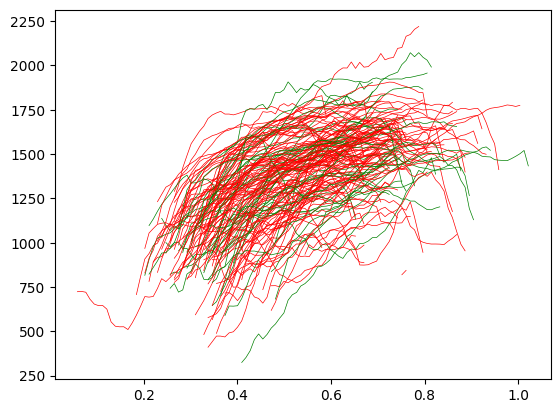

In [85]:
import numpy as np
import pandas as pd
import math
from scipy import signal

ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
dist_to_emb = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []
q1_solidity = []
q2_solidity = []

appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []
for id_, group1 in full_pn1_df.groupby('embryo_id'):
    # First PN: fill NaNs, compute time, extract active segment
    group1 = group1.copy()
    group1['area'] = group1['area'].fillna(1)
    group1['time'] = group1['dt'].cumsum()
    start1, len1 = find_signal(group1['area'].values != 1)
    first_pn = group1.iloc[start1 : start1 + len1].reset_index(drop=True)

    # Second PN: same steps
    group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy()
    group2['area'] = group2['area'].fillna(1)
    group2['time'] = group2['dt'].cumsum()
    start2, len2 = find_signal(group2['area'].values != 1)
    second_pn = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

    whole_emb_slice = whole_emb_all_df.iloc[start1 : start1 + len1]

    appear_pn1.append(first_pn.iloc[0]['time'])
    appear_pn2.append(second_pn.iloc[0]['time'])

    dt_appear.append(second_pn.iloc[0]['time']-first_pn.iloc[0]['time'])

    fade_pn1.append(first_pn.iloc[-1]['time'])
    fade_pn2.append(second_pn.iloc[-1]['time'])

    init_size1.append(first_pn['area'].iloc[:5].mean()/second_pn['area'].iloc[:5].mean())

    dx = first_pn['x'].values  - group2['x'].iloc[start1 : start1 + len1].values
    dy = first_pn['y'].values  - group2['y'].iloc[start1 : start1 + len1].values
    angle_rad = np.atan2(dy, dx)       # result in radians, ∈ (−π,π]
    angle_deg = np.degrees(angle_rad[~np.isnan(angle_rad)])


    max_size.append(first_pn['area'].max())
    q1_size.append(first_pn['area'].quantile(0.1))
    q2_size.append(first_pn['area'].quantile(0.9))
    avg_degree.append(np.quantile(angle_deg,0.1))

    eccentricity_to_embryo = np.sqrt(
        (first_pn['x'].values - whole_emb_slice['x'].values)**2 +
        (first_pn['y'].values - whole_emb_slice['y'].values)**2
    )
    
    dist_to_emb.append(eccentricity_to_embryo[~np.isnan(eccentricity_to_embryo)].mean())
    dist = np.sqrt(
        (group1['x'].values - group2['x'].values)**2 +
        (group1['y'].values - group2['y'].values)**2
    )
  
    dists.append(dist[~np.isnan(dist)].mean())

    # Offset difference
    offset_diff = (start2 + len2) - (start1 + len1)
    if offset_diff != 0:
        ids.append(id_)
        offsets.append(offset_diff)

    # Perimeter cross-correlation
    sig1 = first_pn['area']
    sig2 = second_pn['area']
    corr = signal.correlate(sig1, sig2)
    peak = corr.max()
    norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
    peak_norm = peak / norm if norm != 0 else 0
    peak_norms.append(peak_norm)

    # Area ratio (onl
    
    import statsmodels.api as sm
    mod = sm.OLS( first_pn['area'].values, first_pn['time'].values)
    res = mod.fit()
    
    slope1.append(res.params[0])


    mod = sm.OLS(second_pn['area'].values,second_pn['time'].values, )
    res = mod.fit()

    slope2.append(res.params[0])

    smmoothen_pn1 = first_pn[['time','area']].rolling(12).mean()
    
    embryo_lbl = merged_df.loc[merged_df['embryo_id']==id_]['y'].values[0]

    plt.plot( smmoothen_pn1['time'].values,smmoothen_pn1['area'].values,color='red' if embryo_lbl==0 else 'green', lw=-.5)

In [81]:
embryo_labl.values[0]

np.int64(0)

<Axes: >

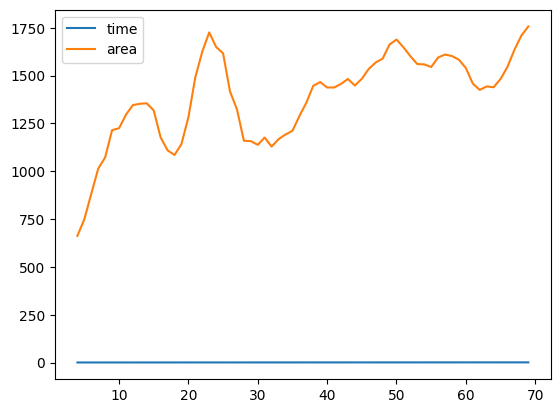

In [74]:
first_pn[['time','area']].rolling(5).mean().plot()

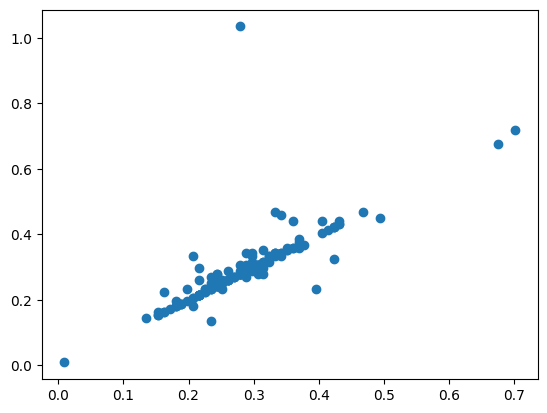

In [56]:
plt.scatter(appear_pn1,appear_pn2)

In [ ]:

from scipy.stats import pointbiserialr
print(pointbiserialr(merged_df['y'], slope1))
print(pointbiserialr(merged_df['y'], slope2))
print(pointbiserialr(merged_df['y'], dists))
print(pointbiserialr(merged_df['y'], dist_to_emb))
print(pointbiserialr(merged_df['y'], init_size1))
print(pointbiserialr(merged_df['y'], max_size))
print(pointbiserialr(merged_df['y'], q1_size))
print(pointbiserialr(merged_df['y'], q2_size))
pointbiserialr(merged_df['y'],appear_pn1 )
pointbiserialr(merged_df['y'],appear_pn2 )

SignificanceResult(statistic=np.float64(-0.20290093919007593), pvalue=np.float64(0.011890239249898446))
SignificanceResult(statistic=np.float64(-0.2027018027514938), pvalue=np.float64(0.011975552193802556))
SignificanceResult(statistic=np.float64(-0.22346045691430616), pvalue=np.float64(0.005493314148431362))
SignificanceResult(statistic=np.float64(0.19491036995311273), pvalue=np.float64(0.01576378563131904))
SignificanceResult(statistic=np.float64(-0.19185177583075486), pvalue=np.float64(0.017514428485424716))
SignificanceResult(statistic=np.float64(-0.18296266990956395), pvalue=np.float64(0.02359212674680967))
SignificanceResult(statistic=np.float64(-0.2744126419390261), pvalue=np.float64(0.0005978290403387321))
SignificanceResult(statistic=np.float64(-0.19592356101624636), pvalue=np.float64(0.015218478627989458))


In [51]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size,q2_size]).transpose()

In [40]:
from sklearn.linear_model import LinearRegression


r2 = LinearRegression().fit(X, y).score(X, y)
print(f"Combined R²: {r2:.3f}")

NameError: name 'y' is not defined

In [65]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'],dt_appear )

SignificanceResult(statistic=np.float64(0.02543656556569698), pvalue=np.float64(0.7549620911259425))

In [ ]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'], slope2 )

SignificanceResult(statistic=np.float64(-0.2027018027514938), pvalue=np.float64(0.011975552193802556))

In [ ]:
from scipy.stats import pointbiserialr, norm
import numpy as np

# 1. compute r and p
r, p = pointbiserialr(merged_df['y'], slope1)
n = len(merged_df)

# 2. Fisher z-transform and standard error
z = np.arctanh(r)
se = 1/np.sqrt(n - 3)

# 3. critical z for 95% CI
z_crit = norm.ppf(1 - 0.05/2)

# 4. CI in z-space, then back-transform to r
lo_z, hi_z = z - z_crit*se, z + z_crit*se
lo_r, hi_r = np.tanh([lo_z, hi_z])

print(f"r = {r:.3f}, p = {p:.3g}")
print(f"95% CI for r = ({lo_r:.3f}, {hi_r:.3f})")


r = 0.215, p = 0.00762
95% CI for r = (0.058, 0.361)


In [ ]:
merged_df.loc[merged_df['embryo_id'].isin(ids)]['y']

9      0
19     0
20     0
47     0
50     0
66     1
72     1
91     0
94     0
105    0
108    0
134    0
143    1
152    0
Name: y, dtype: int64

In [ ]:
merged_df.loc[merged_df['embryo_id'].isin(ids)]['y'].sum()

np.int64(3)

In [ ]:
important_['time'].cumsum()

17419     156.780
17420     313.569
17421     470.367
17422     627.174
17423     783.990
17424     940.815
17425    1097.649
17426    1254.492
17427    1411.344
17428    1568.205
17429    1725.075
17430    1881.954
17431    2038.842
17432    2195.739
17433    2352.645
17434    2509.560
17435    2666.484
17436    2823.417
17437    2980.359
17438    3137.310
17439    3294.270
17440    3451.239
17441    3608.217
17442    3765.204
17443    3922.200
17444    4079.205
17445    4236.219
17446    4393.242
17447    4550.274
17448    4707.315
17449    4864.365
17450    5021.424
17451    5178.492
17452    5335.569
17453    5492.655
17454    5649.750
17455    5806.854
17456    5963.967
17457    6121.089
17458    6278.220
17459    6435.360
17460    6592.509
17461    6749.667
17462    6906.834
17463    7064.010
17464    7221.195
17465    7378.389
17466    7535.592
17467    7692.804
17468    7850.025
17469    8007.255
17470    8164.494
17471    8321.742
Name: time, dtype: float64

In [ ]:
means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

q1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.1))

q2 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.9))



/tmp/ipykernel_9917/2096497004.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())
/tmp/ipykernel_9917/2096497004.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())
/tmp/ipykernel_9917/2096497004.py:5: DeprecationWarning: DataFrameGroupBy.a

In [ ]:
simple_features =['area']

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
# ...
from tsfresh.feature_extraction import extract_features
settings = ComprehensiveFCParameters()
# Set here the options of the settings object as shown in the paragraphs below


extracted_features = extract_features(full_pn1_df[simple_features+['time','embryo_id']].fillna(0), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features2 = extract_features(full_pn2_df[simple_features+['time','embryo_id']].fillna(0), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 77/77 [00:00<00:00, 184.33it/s]


In [ ]:

both_pn_extracted = pd.merge(extracted_features, extracted_features2, left_index=True, right_index=True)
non_dead_features = list(both_pn_extracted.var().loc[(both_pn_extracted.var()>100)].index)

In [ ]:
extracted_features = extracted_features.reset_index(names='embryo_id')

extracted_features2 = extracted_features2.reset_index(names='embryo_id')

In [ ]:


both_pn_extracted = both_pn_extracted.reset_index(names='embryo_id')

In [ ]:
with_targ

,y,embryo_id,area__sum_values_x,area__abs_energy_x,area__mean_abs_change_x,area__median_x,area__mean_x,area__standard_deviation_x,area__variance_x,area__root_mean_square_x,...,"solidity__fft_coefficient__attr_""angle""__coeff_92_y","solidity__fft_coefficient__attr_""angle""__coeff_93_y","solidity__fft_coefficient__attr_""angle""__coeff_94_y","solidity__fft_coefficient__attr_""angle""__coeff_95_y","solidity__fft_coefficient__attr_""angle""__coeff_96_y","solidity__fft_coefficient__attr_""angle""__coeff_97_y","solidity__fft_coefficient__attr_""angle""__coeff_98_y","solidity__fft_coefficient__attr_""angle""__coeff_99_y","solidity__fft_aggregated__aggtype_""variance""_y",solidity__value_count__value_0_y
0,0,D2017.01.25_S1483_I149_1,86789.0,126436419.0,86.693467,0.0,433.945,666.238570,443873.831975,795.098796,...,25.731286,-122.413656,-26.839657,156.798084,-120.589397,-137.683369,-159.011892,-127.908304,961.397065,129.0
1,0,D2017.01.25_S1483_I149_10,96918.0,128283098.0,149.658291,0.0,484.590,637.642550,406588.021900,800.884193,...,148.408806,-37.253228,162.757841,-68.064679,-45.687519,133.512139,1.981941,156.783639,1046.531329,112.0
2,0,D2017.01.25_S1483_I149_12,91514.0,115935342.0,71.145729,0.0,457.570,608.528064,370306.405100,761.365031,...,59.371619,-115.033469,-37.316942,-155.384352,-121.748468,157.669813,-34.318321,26.781960,942.898148,120.0
3,1,D2017.01.25_S1483_I149_3,102970.0,124383958.0,176.809045,195.0,514.850,597.368619,356849.267500,788.618913,...,-127.591669,-71.670935,-92.134664,107.564827,-89.762819,114.948494,-179.475715,139.035938,1060.936262,103.0
4,1,D2017.01.25_S1483_I149_4,87131.0,122337747.0,108.140704,0.0,435.655,649.533260,421893.455975,782.105322,...,-102.372424,-168.338622,141.341986,-147.263787,72.466588,-160.504407,56.750921,-118.197116,1095.245225,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,D2019.04.16_S01982_I0149_D_5,84515.0,110466731.0,74.381910,0.0,422.575,611.362433,373764.024375,743.191533,...,48.976616,-172.261802,21.449539,-172.737562,8.702333,80.406165,80.214345,144.584318,915.882040,129.0
149,0,D2019.04.16_S01982_I0149_D_7,98238.0,136404574.0,110.211055,0.0,491.190,663.894008,440755.253900,825.846759,...,49.651930,133.070783,129.492046,-165.064279,-100.341964,-130.957088,-32.334013,-102.597182,1019.370009,109.0
150,0,D2019.04.20_S01983_I0149_D_5,66556.0,84176616.0,61.728643,0.0,332.780,556.902641,310140.551600,648.755023,...,127.592340,-37.807211,160.702588,-40.450203,131.274395,-36.731346,28.827947,-144.710554,941.113120,141.0
151,1,D2019.04.22_S01986_I0149_D_10,74341.0,87454089.0,113.015075,0.0,371.705,546.905694,299105.837975,661.264278,...,62.789661,122.396513,117.906721,-145.671092,-0.718011,132.631354,-101.786663,-29.500766,1022.930323,124.0


In [ ]:
with_targ = pd.merge(merged_df[['y','embryo_id']], both_pn_extracted[non_dead_features+['embryo_id']], on='embryo_id', how='right')

In [ ]:
with_targ.drop('embryo_id',axis=1).corr()['y'].abs().sort_values()

area__fft_coefficient__attr_"real"__coeff_4_y     0.000025
area__fft_coefficient__attr_"real"__coeff_91_x    0.000067
area__fft_coefficient__attr_"imag"__coeff_59_x    0.000136
area__fft_coefficient__attr_"abs"__coeff_88_x     0.000282
area__fft_coefficient__attr_"imag"__coeff_5_x     0.000318
                                                    ...   
area__fft_coefficient__attr_"imag"__coeff_37_x    0.227834
area__fft_coefficient__attr_"real"__coeff_19_y    0.230667
area__fft_coefficient__attr_"abs"__coeff_83_x     0.235890
area__fft_coefficient__attr_"abs"__coeff_10_x     0.241830
y                                                 1.000000
Name: y, Length: 1127, dtype: float64

In [ ]:
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,confusion_matrix

In [ ]:
# X = with_targ.drop(['y','embryo_id'],axis=1)
y = merged_df['y']

In [ ]:
pn1_features['time'] = pn1_features['dt'].cumsum()
pn2_features['time'] = pn2_features['dt'].cumsum()

In [ ]:

train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [ ]:
X.transpose().shape

(153, 8)

In [ ]:
folds = StratifiedKFold(5,random_state=3, shuffle=True)
for train_idx, test_idx in folds.split(X,y):


    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y.loc[train_idx], y.loc[test_idx]


    # decent_corr_features = list(X_train.corrwith(y_train).abs().sort_values().tail(15000).index)
    clf = RandomForestClassifier()
    pca = PCA(n_components=100)
    clf.fit(X_train, y_train)
    print(confusion_matrix(y_test,clf.predict_proba(X_test)[:,1]>.3))


[[10 13]
 [ 4  4]]
[[18  5]
 [ 4  4]]
[[19  4]
 [ 4  4]]
[[19  4]
 [ 4  3]]
[[19  3]
 [ 4  4]]


In [ ]:
y_test

NameError: name 'y_test' is not defined

In [ ]:
pd.DataFrame(pn1_features)['area'].iloc[:100].argsort()

/tmp/ipykernel_9219/4016114416.py:1: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  pd.DataFrame(pn1_features)['area'].iloc[:100].argsort()


0     -1
1     -1
2     -1
3      1
4      6
      ..
95    -1
96    51
97    -1
98    -1
99    -1
Name: area, Length: 100, dtype: int64

<Axes: >

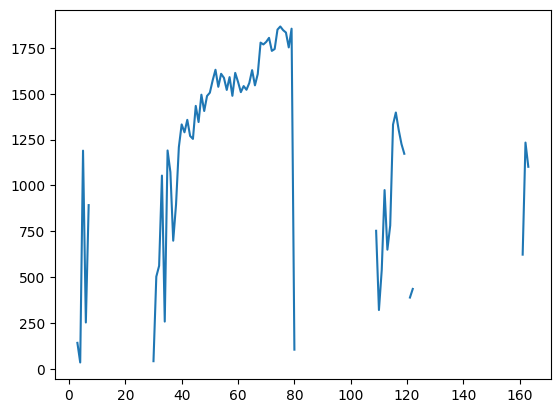

In [ ]:
pd.DataFrame(pn1_features)['area'].plot()
# pd.DataFrame(pn2_features)['x'].plot()

<Axes: >

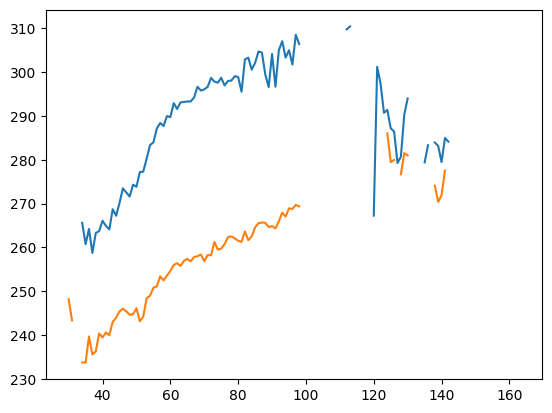

In [ ]:
pd.DataFrame(pn1_features)['x'].plot()
pd.DataFrame(pn2_features)['x'].plot()

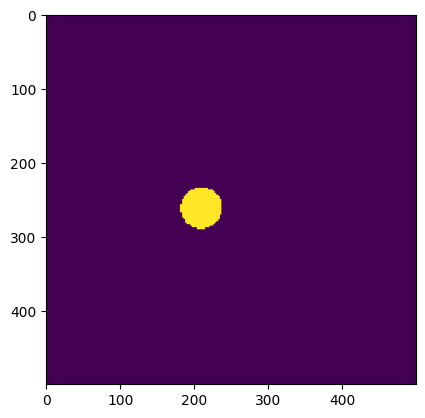

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks[83][1])